# Q-Learning on environment (CartPole) with Large State Space

## Create Environment, Initialize it, Know dtails about observation_space and action_space

In [2]:
import gym
env=gym.make("CartPole-v0")
obsrvation=env.reset()
print(env.observation_space.shape)
print(env.observation_space.low)
print(env.observation_space.high)
print(env.action_space.n)

(4,)
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
2


## To perform specific action and see the next state

In [3]:
import gym
import time
env = gym.make('CartPole-v0')
env.reset()
env.render()
time.sleep(1)
for i in range(10):
    env.step(0)#right
    env.render()
    time.sleep(1)
env.close()

# Human Play

In [24]:
max_steps_per_episode=200
for episode in range(2):
    # initialize new episode params
    observation = env.reset()
    done = False
    print("*****EPISODE ", episode+1, "*****\n\n\n\n")
    time.sleep(1)
    for step in range(max_steps_per_episode):        
        # Show current state of environment on screen
        env.render()
        time.sleep(0.3)
        action=int(input())
        observation, reward, done, info = env.step(action)
        if done:
            env.render()
            break
        
env.close()

## Random Play

In [18]:
import gym
import numpy
env=gym.make("CartPole-v0")
done=False
obsrvation=env.reset()
c=0
while not done:
    env.render()
    action=env.action_space.sample()
    obsrvation,reward,done,_=env.step(action)
    #print(obsrvation)
    c+=1
    if done:
        break
env.close()
print("Length of Episode",c)

Length of Episode 27


In [19]:
#try to chek what will be rendered evn after pole fall
import gym
env = gym.make('CartPole-v0')
env.reset()
c=0
for _ in range(1000):
    env.render()
    c+=1
    s,r,d,oth=env.step(env.action_space.sample()) #
print(c)
env.close()

1000


## Q Learning

0 1.0000 9.0
100 0.0995 29.0
200 0.0705 31.0
300 0.0576 26.0
400 0.0499 20.0
500 0.0447 200.0
600 0.0408 118.0
700 0.0378 171.0
800 0.0353 200.0
900 0.0333 131.0


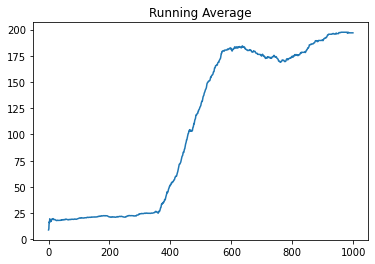

In [25]:
import os
import gym
import numpy as np 
import matplotlib.pyplot as plt 
import random
seed=12
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed) 
np.random.seed(seed)
env = gym.make('CartPole-v0')
env.seed(seed)
env.action_space.seed(seed)
MAXSTATES = 10**4
GAMMA = 0.9
ALPHA = 0.01

def max_dict(d):
    max_v = float('-inf')
    for key, val in d.items():
        if val > max_v:
            max_v = val
            max_key = key
    return max_key, max_v

def create_bins():
    # obs[0] -> cart position --- -4.8 - 4.8
    # obs[1] -> cart velocity --- -inf - inf
    # obs[2] -> pole angle    --- -41.8 - 41.8
    # obs[3] -> pole velocity --- -inf - inf
    bins = np.zeros((4,10))
    bins[0] = np.linspace(-4.8, 4.8, 10)
    bins[1] = np.linspace(-5, 5, 10)
    bins[2] = np.linspace(-.418, .418, 10)
    bins[3] = np.linspace(-5, 5, 10)

    return bins

def assign_bins(observation, bins):
    state = np.zeros(4)
    for i in range(4):
        #state[i] contain bin number for all four observations
        state[i] = np.digitize(observation[i], bins[i])
    return state

def get_state_as_string(state):
    string_state = ''.join(str(int(e)) for e in state)
    return string_state

def get_all_states_as_string():
    states = []
    for i in range(MAXSTATES):
        states.append(str(i).zfill(4))
    return states

def initialize_Q():
    Q = {}

    all_states = get_all_states_as_string()  ### 0: "0000", 1:"0001",..,12:"0012",  152: "0152",.., 9999:"9999"
    for state in all_states:
        Q[state] = {}
        for action in range(env.action_space.n):
            Q[state][action] = 0.0
    return Q

def play_one_game(bins, Q, eps=0.5):
    observation = env.reset()
    done = False
    cnt = 0 # number of moves in an episode
    state = get_state_as_string(assign_bins(observation, bins)) #[5 4 2 1], 5421
  
    total_reward = 0

    while not done:
        #env.render()
        cnt += 1
        # np.random.randn() seems to yield a random action 50% of the time ?
        if np.random.uniform() < eps:
            act = env.action_space.sample() # epsilon greedy
        else:
            act = max_dict(Q[state])[0]

        observation, reward, done, _ = env.step(act)

        total_reward += reward

        if done and cnt < 200:
            reward = -300

        state_new = get_state_as_string(assign_bins(observation, bins))
        
        a1, max_q_s1a1 = max_dict(Q[state_new])
        Q[state][act] += ALPHA*(reward + GAMMA*max_q_s1a1 - Q[state][act])
        state, act = state_new, a1
    env.close()
    return total_reward, cnt

def play_many_games(bins, N=50):
    global Q
    length = []
    reward = []
    for n in range(N):
        #eps=0.5/(1+n*10e-3)
        eps = 1.0 / np.sqrt(n+1)

        episode_reward, episode_length = play_one_game(bins, Q, eps)
        if n % 100 == 0:
            print(n, '%.4f' % eps, episode_reward)
        length.append(episode_length)
        reward.append(episode_reward)

    return length, reward

def plot_running_avg(totalrewards):
    N = len(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(totalrewards[max(0, t-100):(t+1)])
    plt.plot(running_avg)
    plt.title("Running Average")
    plt.show()

if __name__ == '__main__':
    Q = initialize_Q()
    bins = create_bins()
    episode_lengths, episode_rewards = play_many_games(bins)
    plot_running_avg(episode_rewards)

### Lets Auto Control

In [27]:
def play():
    max_steps_per_episode=200
    for episode in range(3):
        # initialize new episode params
        observation = env.reset()
        done = False
        print("*****EPISODE ", episode+1, "*****\n")
        #time.sleep(1)
        length=0
        for step in range(max_steps_per_episode):        
            # Show current state of environment on screen
            env.render()
            time.sleep(0.3)
            # Choose action with highest Q-value for current state       
            state = get_state_as_string(assign_bins(observation, bins))
            action = max_dict(Q[state])[0]  #np.argmax(q_table[state,:])        
            # Take action
            observation, reward, done, info = env.step(action)
            length+=1
            if done:
                env.render()
                break
        print("Length of Episode {0} is {1}".format(episode,length))
    env.close()

*****EPISODE  1 *****




Length of Episode 0 is 200
*****EPISODE  2 *****




Length of Episode 1 is 200
*****EPISODE  3 *****




Length of Episode 2 is 200


## Train for Longer time and then play

In [ ]:
Q = initialize_Q()
bins = create_bins()
episode_lengths, episode_rewards = play_many_games(bins)
plot_running_avg(episode_rewards)

In [ ]:
play()